# Titanic Data Wrangling

Titanic のデータを学習で使えるように、いろんな加工をする。

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
train_df = pd.read_csv ('train.csv')
test_df = pd.read_csv ('test.csv')

## 不要なデータ列の削除

まずは使えなさそうな列を削除する。
* PassengerId
    * Kaggle が勝手に振った ID なのでいらないはず
    * ただし test_df のほうは、あとで使う (出力データとして) のでいったん残しておく
* Ticket
    * 必要な情報はなさそうである
* Cabin
    * 欠損が多すぎて補完するのも難しいので、削除する

In [3]:
train_df = train_df.drop (["PassengerId", "Ticket", "Cabin"], axis=1)
print (train_df.shape)
test_df = test_df.drop (["Ticket", "Cabin"], axis=1)
print (test_df.shape)

(891, 9)
(418, 9)


## 'Name' から 'Title' を抽出し、Sex/Age/Survived と相関があるか

In [4]:
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print (train_df.count())
print (test_df.count ())

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Embarked    889
Title       891
dtype: int64
PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Fare           417
Embarked       418
Title          418
dtype: int64


一応、すべてのエントリーに Title はあるらしい

In [5]:
pd.crosstab (train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


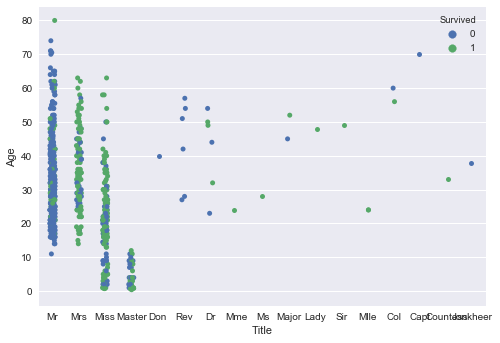

In [6]:
sns.stripplot (x='Title', y='Age', data=train_df, hue='Survived', jitter=True)

* 主要な Title は 4 つ
    * Mr: 男性、10-80歳
    * Mrs: 女性、10-70歳 (年上が多い)
    * Miss: 女性、0-70歳 (年下が多い)
    * Master: 男性、0-15歳
* 'Title' と 'Age' は相関がありそうだ
* 'Title' と 'Survived' にも相関がありそうだけど、ただ単に 'Age' 'Sex' との相関を表しているだけかもしれない

Title があれば、Name は消して良いと思うので、Name を削除する

In [7]:
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
print (train_df.shape, test_df.shape)

(891, 9) (418, 9)


## 'Age' 欠損値の補完

'Age' は重要なファクターだが欠損している。<br>
'Pclass' や 'Sex'、または 'Title' あたりと相関がありそうなので、そのあたりを再度探りつつ補完する。

### 'Age', 'Pclass', 'Sex'

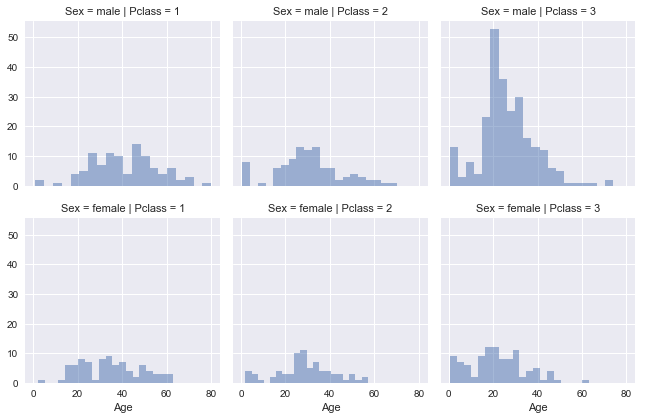

In [8]:
grid = sns.FacetGrid (data=train_df, row='Sex', col='Pclass')
grid.map (plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend ()

### 'Age', 'Pclass', 'Title'

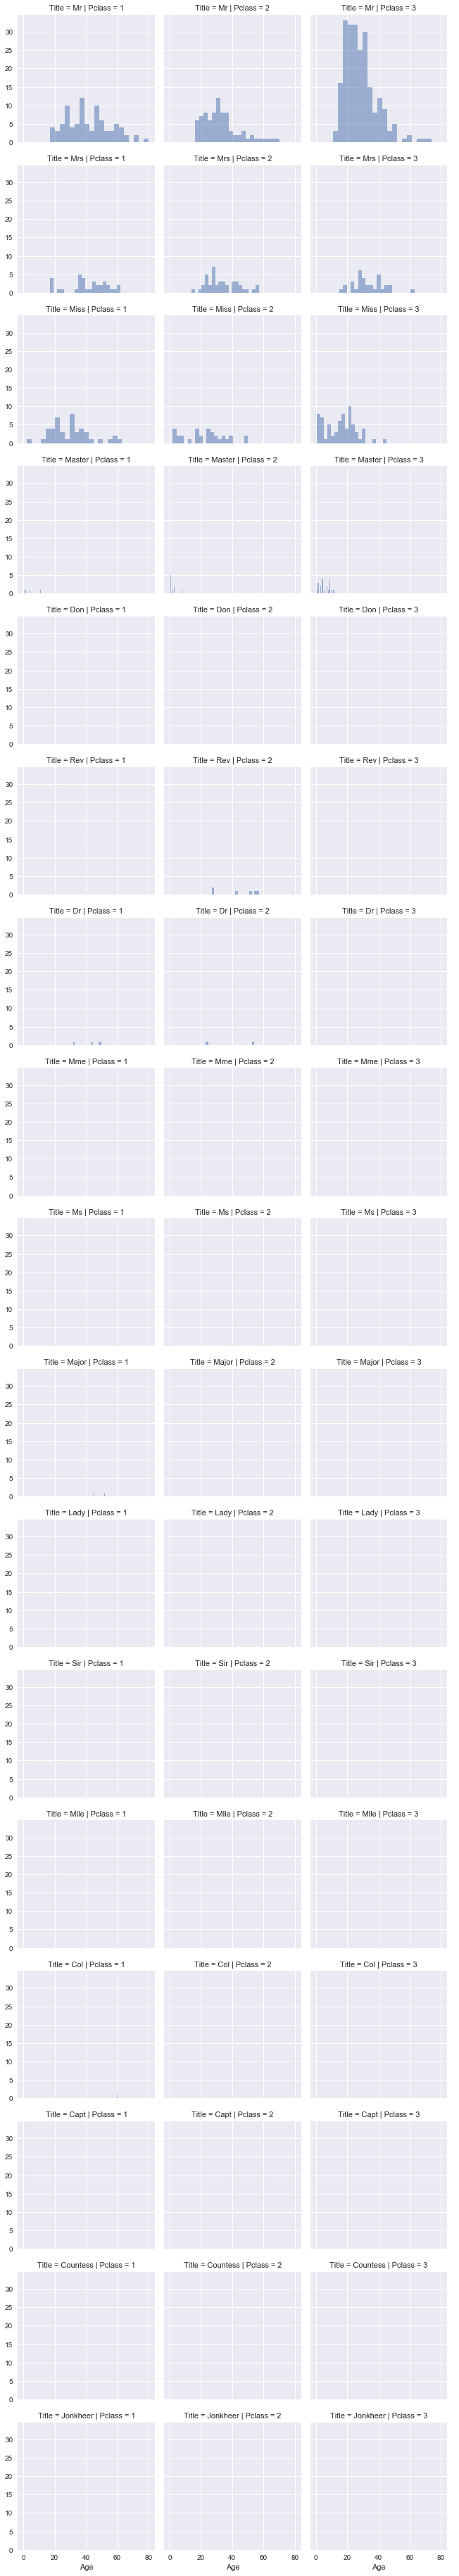

In [9]:
grid = sns.FacetGrid (data=train_df, row='Title', col='Pclass')
grid.map (plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend ()

こちらのほうが良さそうなので、こっちで。<br>
ここで Title, Pclass, Sex の関連をいったん出力してみる。

In [10]:
pd.crosstab (train_df['Title'], [train_df['Pclass'], train_df['Sex']])

Pclass        1           2           3     
Sex      female male female male female male
Title                                       
Capt          0    1      0    0      0    0
Col           0    2      0    0      0    0
Countess      1    0      0    0      0    0
Don           0    1      0    0      0    0
Dr            1    4      0    2      0    0
Jonkheer      0    1      0    0      0    0
Lady          1    0      0    0      0    0
Major         0    2      0    0      0    0
Master        0    3      0    9      0   28
Miss         46    0     34    0    102    0
Mlle          2    0      0    0      0    0
Mme           1    0      0    0      0    0
Mr            0  107      0   91      0  319
Mrs          42    0     41    0     42    0
Ms            0    0      1    0      0    0
Rev           0    0      0    6      0    0
Sir           0    1      0    0      0    0

In [11]:
pd.crosstab (test_df['Title'], [test_df['Pclass'], test_df['Sex']])

Pclass      1           2           3     
Sex    female male female male female male
Title                                     
Col         0    2      0    0      0    0
Dona        1    0      0    0      0    0
Dr          0    1      0    0      0    0
Master      0    2      0    2      0   17
Miss       14    0     16    0     48    0
Mr          0   52      0   59      0  129
Mrs        35    0     14    0     23    0
Ms          0    0      0    0      1    0
Rev         0    0      0    2      0    0

In [12]:
guess_ages = np.zeros ((17, 3))
guess_ages_t = np.zeros ((9, 3))

[公式ドキュメント](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.sort_values.html) をもとに、ソートしてユニーク値をリスト化する。

In [13]:
title_list = train_df['Title'].sort_values (inplace=False).unique ()
print (title_list)
pclass_list = train_df['Pclass'].sort_values (inplace=False).unique ()
print (pclass_list)

['Capt' 'Col' 'Countess' 'Don' 'Dr' 'Jonkheer' 'Lady' 'Major' 'Master'
 'Miss' 'Mlle' 'Mme' 'Mr' 'Mrs' 'Ms' 'Rev' 'Sir']
[1 2 3]


In [14]:
title_list_t = test_df['Title'].sort_values (inplace=False).unique ()
print (title_list_t)
pclass_list_t = test_df['Pclass'].sort_values (inplace=False).unique ()
print (pclass_list_t)

['Col' 'Dona' 'Dr' 'Master' 'Miss' 'Mr' 'Mrs' 'Ms' 'Rev']
[1 2 3]


In [15]:
# train_df
for i, title in enumerate(title_list):
    for j, pclass in enumerate(pclass_list):
        guess_df = train_df[(train_df['Title'] == title) & (train_df['Pclass'] == pclass)]['Age'].dropna ()
        guess_ages[i,j] = guess_df.median ()
        
# test_df
for i, title in enumerate(title_list_t):
    for j, pclass in enumerate(pclass_list_t):
        guess_df = test_df[(test_df['Title'] == title) & (test_df['Pclass'] == pclass)]['Age'].dropna ()
        guess_ages_t[i,j] = guess_df.median ()


In [16]:
guess_ages

array([[ 70. ,   nan,   nan],
       [ 58. ,   nan,   nan],
       [ 33. ,   nan,   nan],
       [ 40. ,   nan,   nan],
       [ 46.5,  38.5,   nan],
       [ 38. ,   nan,   nan],
       [ 48. ,   nan,   nan],
       [ 48.5,   nan,   nan],
       [  4. ,   1. ,   4. ],
       [ 30. ,  24. ,  18. ],
       [ 24. ,   nan,   nan],
       [ 24. ,   nan,   nan],
       [ 40. ,  31. ,  26. ],
       [ 41.5,  32. ,  31. ],
       [  nan,  28. ,   nan],
       [  nan,  46.5,   nan],
       [ 49. ,   nan,   nan]])

In [17]:
guess_ages_t

array([[ 50. ,   nan,   nan],
       [ 39. ,   nan,   nan],
       [ 53. ,   nan,   nan],
       [  9.5,   5. ,   7. ],
       [ 32. ,  19.5,  22. ],
       [ 42. ,  28. ,  25. ],
       [ 48. ,  29. ,  28. ],
       [  nan,   nan,   nan],
       [  nan,  35.5,   nan]])

In [18]:
pd.crosstab (train_df['Title'], train_df['Pclass'])

Pclass,1,2,3
Title,,,
Capt,1,0,0
Col,2,0,0
Countess,1,0,0
Don,1,0,0
Dr,5,2,0
Jonkheer,1,0,0
Lady,1,0,0
Major,2,0,0
Master,3,9,28


In [19]:
pd.crosstab (test_df['Title'], test_df['Pclass'])

Pclass,1,2,3
Title,,,
Col,2,0,0
Dona,1,0,0
Dr,1,0,0
Master,2,2,17
Miss,14,16,48
Mr,52,59,129
Mrs,35,14,23
Ms,0,0,1
Rev,0,2,0


これで一応、全部の年齢推測ができたっぽい。<br>
NaN のところに、この推測値を適用する。

In [20]:
train_df[train_df['Age'].isnull()].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
5,0,3,male,NaN,0,0,8.4583,Q,Mr
17,1,2,male,NaN,0,0,13.0000,S,Mr
19,1,3,female,NaN,0,0,7.2250,C,Mrs
26,0,3,male,NaN,0,0,7.2250,C,Mr
28,1,3,female,NaN,0,0,7.8792,Q,Miss


In [21]:
for i, title in enumerate(title_list):
    for j, pclass in enumerate(pclass_list):
        train_df.loc[(train_df['Age'].isnull()) & (train_df['Title'] == title) & (train_df['Pclass'] == pclass), 'Age'] = guess_ages[i,j]
        
train_df[:30]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr
5,0,3,male,26.0,0,0,8.4583,Q,Mr
6,0,1,male,54.0,0,0,51.8625,S,Mr
7,0,3,male,2.0,3,1,21.0750,S,Master
8,1,3,female,27.0,0,2,11.1333,S,Mrs
9,1,2,female,14.0,1,0,30.0708,C,Mrs


In [22]:
train_df.count()

Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch       891
Fare        891
Embarked    889
Title       891
dtype: int64

同じことを test_df にも行う。

In [23]:
test_df[test_df['Age'].isnull()].head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
10,902,3,male,NaN,0,0,7.8958,S,Mr
22,914,1,female,NaN,0,0,31.6833,S,Mrs
29,921,3,male,NaN,2,0,21.6792,C,Mr
33,925,3,female,NaN,1,2,23.4500,S,Mrs
36,928,3,female,NaN,0,0,8.0500,S,Miss


In [24]:
for i, title in enumerate(title_list_t):
    for j, pclass in enumerate(pclass_list_t):
        test_df.loc[(test_df['Age'].isnull()) & (test_df['Title'] == title) & (test_df['Pclass'] == pclass), 'Age'] = guess_ages_t[i,j]
        
test_df[:30]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,Mr
1,893,3,female,47.0,1,0,7.0000,S,Mrs
2,894,2,male,62.0,0,0,9.6875,Q,Mr
3,895,3,male,27.0,0,0,8.6625,S,Mr
4,896,3,female,22.0,1,1,12.2875,S,Mrs
5,897,3,male,14.0,0,0,9.2250,S,Mr
6,898,3,female,30.0,0,0,7.6292,Q,Miss
7,899,2,male,26.0,1,1,29.0000,S,Mr
8,900,3,female,18.0,0,0,7.2292,C,Mrs
9,901,3,male,21.0,2,0,24.1500,S,Mr


In [25]:
test_df[test_df['Age'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
88,980,3,female,NaN,0,0,7.75,Q,Ms


あ、あれ。。。<br>
Ms はこの一人しかおらず、欠損していることが判明。。<br>
仕方ないので、train_df にいる Ms のデータで補完することにする。<br>
Pclass が違うが、仕方ない。。

In [26]:
guess_df = train_df[train_df['Title'] == 'Ms']['Age'].dropna ()
test_df.loc[test_df['Age'].isnull(), 'Age'] = guess_df.median ()

In [27]:
test_df.count ()

PassengerId    418
Pclass         418
Sex            418
Age            418
SibSp          418
Parch          418
Fare           417
Embarked       418
Title          418
dtype: int64

これで Age 欠損値の補完ができた。

## Age band の作成

Age はある程度のまとまりを作ったほうが良さそう。<br>
小さい子の生存確率は高いというのを確かめてみる。

In [28]:
train_df["AgeBand"] = pd.cut (train_df['Age'], 10)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean ().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 8.378]",0.655172
1,"(8.378, 16.336]",0.413043
2,"(16.336, 24.294]",0.396226
3,"(24.294, 32.252]",0.291367
4,"(32.252, 40.21]",0.413043
5,"(40.21, 48.168]",0.405063
6,"(48.168, 56.126]",0.466667
7,"(56.126, 64.084]",0.375000
8,"(64.084, 72.042]",0.000000
9,"(72.042, 80]",0.500000


* 8 歳以下は生存確率が有意に高いように見える
* 72 歳以上も高いが、これはデータポイントが少ないからたまたまだろう
    * なのでこのあたりはもっと大きく区切らないといけない

In [29]:
train_df["AgeBand"] = pd.cut (train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean ().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.548077
1,"(16.336, 32.252]",0.336735
2,"(32.252, 48.168]",0.410138
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80]",0.090909


* 16 歳以下でくくると、8 歳以下とそれ以上の差が見えなくなる。
* 64 歳以上のくくりはよさそう

であれば、

* [0, 8]
* (8, 16]
* (16, 32]
* (32, 48]
* (48, 64]
* (64, 80]

で区切ることにする。

In [30]:
# train_df と test_df の両方に適用
df_list = [train_df, test_df]
for df in df_list:
    df.loc[df['Age'] <= 8, 'Age'] = 0
    df.loc[(df['Age'] > 8) & (df['Age'] <= 16), 'Age'] = 1
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 2
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 3
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 4
    df.loc[(df['Age'] > 64) & (df['Age'] <= 80), 'Age'] = 5

In [31]:
train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean ().sort_values(by='Age', ascending=True)

,Age,Survived
0,0.0,0.655172
1,1.0,0.413043
2,2.0,0.336735
3,3.0,0.410138
4,4.0,0.434783
5,5.0,0.090909


'AgeBand' と 'Title' はもういらなそうなので消す。

In [32]:
train_df = train_df.drop (['AgeBand', 'Title'], axis=1)
train_df.head ()
test_df = test_df.drop (['Title'], axis=1)
test_df.head ()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,3.0,0,0,7.8292,Q
1,893,3,female,3.0,1,0,7.0000,S
2,894,2,male,4.0,0,0,9.6875,Q
3,895,3,male,2.0,0,0,8.6625,S
4,896,3,female,2.0,1,1,12.2875,S


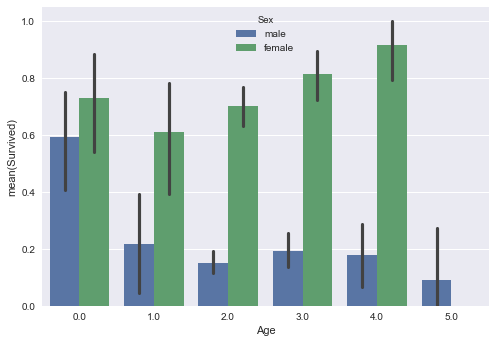

In [33]:
sns.barplot (x='Age', y='Survived', hue='Sex', data=train_df)

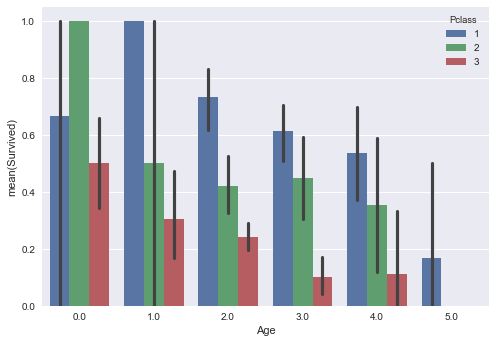

In [34]:
sns.barplot (x='Age', y='Survived', hue='Pclass', data=train_df)

## 家族の数という列の作成

すでに 'SibSp', 'Parch' という列はあるが、これらをまとめてみるとどうなるか。

In [35]:
train_df['Fellow'] = train_df['SibSp'] + train_df['Parch']
train_df[['Fellow', 'Survived']].groupby(['Fellow'], as_index=False).mean ().sort_values (by='Survived', ascending=False)

,Fellow,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


単純な相関ではなさそう。<br>
では、同乗者のあるなしではどうか？

In [36]:
train_df['IsAlone'] = 0
train_df.loc[train_df['Fellow'] == 0, 'IsAlone'] = 1
train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean ().sort_values (by='Survived', ascending=False)

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


独り身のほうが生き残りやすいらしい。<br>
これを作るために使った列 'SibSp', 'Parch', 'Fellow' はいらなそうなので削除。

In [37]:
train_df = train_df.drop (['SibSp', 'Parch', 'Fellow'], axis=1)
train_df.shape

(891, 7)

In [38]:
train_df.head ()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,male,2.0,7.2500,S,0
1,1,1,female,3.0,71.2833,C,0
2,1,3,female,2.0,7.9250,S,1
3,1,1,female,3.0,53.1000,S,0
4,0,3,male,3.0,8.0500,S,1


同じことを test_df にも行う。

In [39]:
test_df['Fellow'] = test_df['SibSp'] + test_df['Parch']
test_df['IsAlone'] = 0
test_df.loc[test_df['Fellow'] == 0, 'IsAlone'] = 1
test_df = test_df.drop (['SibSp', 'Parch', 'Fellow'], axis=1)
test_df.shape

(418, 7)

In [40]:
test_df.head ()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,892,3,male,3.0,7.8292,Q,1
1,893,3,female,3.0,7.0000,S,0
2,894,2,male,4.0,9.6875,Q,1
3,895,3,male,2.0,8.6625,S,1
4,896,3,female,2.0,12.2875,S,0


## Embarked の補完

train_df のほうは、Embarked が 2 つだけ欠損している。<br>
2 つだけなので、適当に、最も多い数を入れてしまう。

In [41]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [42]:
train_df['Embarked'] = train_df['Embarked'].fillna (freq_port)
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


## Fare の補完

test_df のほうは、Fare が 1 つだけ欠損している。<br>
Fare は Pclass と相関がありそうなので、所属する Pclass の中央値で補完する。

In [43]:
print (test_df[test_df['Fare'].isnull()].Pclass)

152    3
Name: Pclass, dtype: int64


In [44]:
guess_df = test_df[test_df['Pclass'] == 3].dropna()
guess_df['Fare'].median()

7.8958

In [45]:
test_df.loc[test_df['Fare'].isnull(), 'Fare'] = guess_df['Fare'].median()
test_df.count()

PassengerId    418
Pclass         418
Sex            418
Age            418
Fare           418
Embarked       418
IsAlone        418
dtype: int64

## 文字列になっているところを、ダミー変数に置き換える

学習で使用できるように、ダミー変数化する。

In [46]:
train_df.head ()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,male,2.0,7.2500,S,0
1,1,1,female,3.0,71.2833,C,0
2,1,3,female,2.0,7.9250,S,1
3,1,1,female,3.0,53.1000,S,0
4,0,3,male,3.0,8.0500,S,1


'Sex' と 'Embarked' をダミー変数にしよう。

In [47]:
df_list = [train_df, test_df]
for df in df_list:
    df['Sex'] = df['Sex'].map ({'female': 0, 'male': 1}).astype (int)
    df['Embarked'] = df['Embarked'].map ({'C': 0, 'Q': 1, 'S': 2}).astype (int)

train_df.head ()

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,0,3,1,2.0,7.2500,2,0
1,1,1,0,3.0,71.2833,0,0
2,1,3,0,2.0,7.9250,2,1
3,1,1,0,3.0,53.1000,2,0
4,0,3,1,3.0,8.0500,2,1


In [48]:
train_df.count()

Survived    891
Pclass      891
Sex         891
Age         891
Fare        891
Embarked    891
IsAlone     891
dtype: int64

In [49]:
test_df.head ()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone
0,892,3,1,3.0,7.8292,1,1
1,893,3,0,3.0,7.0000,2,0
2,894,2,1,4.0,9.6875,1,1
3,895,3,1,2.0,8.6625,2,1
4,896,3,0,2.0,12.2875,2,0


In [50]:
test_df.count ()

PassengerId    418
Pclass         418
Sex            418
Age            418
Fare           418
Embarked       418
IsAlone        418
dtype: int64

## Fare band の作成

Fare は上の方はかなりぶっ飛んでいるので、バンドにまとめたほうがよさそう。

In [51]:
train_df['FareBand'] = pd.qcut (train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby (['FareBand'], as_index=False).mean ().sort_values (by='FareBand', ascending=True)

,FareBand,Survived
0,"[0, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31]",0.454955
3,"(31, 512.329]",0.581081


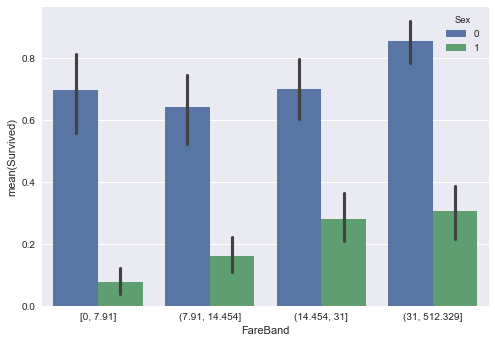

In [52]:
sns.barplot (x='FareBand', y='Survived', hue='Sex', data=train_df)

これでよさそうなので、'Age' と同様にカテゴリーに分ける。

In [53]:
df_list = [train_df, test_df]
for df in df_list:
    df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
    df.loc[df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)
    
train_df = train_df.drop(['FareBand'], axis=1)

これで準備は完了。